In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate, Reshape, Add
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.models import model_from_json
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
def open_and_load(string):
    with open('trained/'+string+'.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('trained/'+string+'.h5')   
    return model

Using TensorFlow backend.


In [2]:
# def change_gen(batch_size=128):
#     while True:
#         a = np.random.randn(batch_size)
#         b = (a > 0)
#         yield a, b       
        
# i = Input(shape=(1,))
# h = Dense(1, activation='relu')(i)
# h = Dense(1, activation='hard_sigmoid')(h)
# change2 = Model(inputs=i, outputs=h)
# change2.compile(loss=mean_squared_error,
#               optimizer='adam')
# change.summary()
# change2.fit_generator(change_gen(), steps_per_epoch=128000, epochs=3)
change2=open_and_load('change')

In [3]:
i = Input(shape=(3,))
# h = Dense(2, use_bias=False)(i) #mby act=none
h = Dense(1,  use_bias=False)(i)
h = change2(h)
change2.trainable=False
h = Lambda(lambda s: K.concatenate([1-s,s]), output_shape=(2,))(h)
border_att = Model(inputs=i, outputs=h)
# border_att.compile(loss=mean_squared_error,
border_att.compile(loss=binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
border_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
model_1 (Model)              (None, 1)                 4         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 7
Trainable params: 3
Non-trainable params: 4
_________________________________________________________________


In [11]:
i = Input(shape=(3,))
border_att.name = 'attention'
h = border_att(i)

b1b2 = Lambda(lambda s: s[:,:2], output_shape=(2,), name='b1b2')(i)
mul = Multiply()([h, b1b2]) 

out = Lambda(lambda s: s[:,0]+s[:,1], output_shape=(1,))(mul)
# out = Dense(1, use_bias=False)(mul)
border = Model(inputs=i, outputs=out)
border.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
border.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
attention (Model)               (None, 2)            7           input_3[0][0]                    
__________________________________________________________________________________________________
b1b2 (Lambda)                   (None, 2)            0           input_3[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 2)            0           attention[1][0]                  
                                                                 b1b2[0][0]                       
__________

In [2]:
i_b2 = Input(shape=(3,))


h_b2 = Dense(3, use_bias=False)(i_b2) #added
h_b2 = Dense(1, use_bias=False)(h_b2)

out_b2 = h_b2
# out = Dense(1, use_bias=False)(mul)
bounce = Model(inputs=i_b2, outputs=out_b2)
bounce.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
bounce.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [3]:
i_b3 = Input(shape=(3,))

h_b3 = Dense(3, use_bias=False)(i_b3) #added
h_b3 = Dense(1, use_bias=False)(h_b3)

out_b3 = h_b3
# out = Dense(1, use_bias=False)(mul)
move = Model(inputs=i_b3, outputs=out_b3)
move.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
move.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [6]:
att = open_and_load('att3') #only pretrained
att.trainable=False
border_att = open_and_load('border_att')
border_att.trainable = False

In [7]:
border_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
_________________________________________________________________
model_1 (Model)              (None, 1)                 4         
_________________________________________________________________
lambda_5 (Lambda)            (None, 2)                 0         
Total params: 7
Trainable params: 0
Non-trainable params: 7
_________________________________________________________________


In [17]:
def gen(batch_size=128):
    while True:
        a = np.zeros((batch_size,4)) #x, v, b1, b2
        a[:,1] = np.random.uniform(0,0.1,size=batch_size)
        a[:,2] = np.random.uniform(-1,-10,size=batch_size)
        a[:,3] = np.random.uniform(1, 10,size=batch_size)
        i = np.random.choice([0,1], size=batch_size) #isb1
        b = a[:,2]*i + a[:,3]*(1-i)
        a[:,1] *= np.sign(1-i-0.5) 
        a[:,0] = np.random.uniform(b, b-2*a[:,1])
        
        isBounce = ( np.abs(a[:,0] + a[:,1]) - np.abs(b)) > 0
        
        v = a[:,1] * np.sign(1-isBounce-0.5) #new speed
        x = (a[:,0] + a[:,1]) * (1-isBounce) + (2*b-a[:,1]-a[:,0])*isBounce
        b_newIsb1 = ((x-a[:,2])/(a[:,3]-a[:,2])) < 0.5
        b_new = a[:,2]*b_newIsb1 + a[:,3]*(1-b_newIsb1)
        y = np.zeros((batch_size,2))
        y[:,0] = x
        y[:,1] = v       
        yield a, y     

In [18]:
def gen_2d(batch_size=128):
    while True:
        a = np.zeros((batch_size, 8))
        y = np.zeros((batch_size,4))
        a[:,:4], y[:,:2] = next(gen(batch_size=batch_size))
        a[:,4:], y[:,2:] = next(gen(batch_size=batch_size))
        yield a, y     

In [10]:
a, b = next(gen_2d())

In [12]:
i = Input(shape=(4,))

x = Lambda(lambda s: s[:,0],name='x')(i)
v = Lambda(lambda s: s[:,1],name='v')(i)
b1 = Lambda(lambda s: s[:,2],name='b1')(i)
b2 = Lambda(lambda s: s[:,3],name='b2')(i)
dropv = Lambda(lambda s: K.stack([s[0],s[1],s[2]], axis=1), output_shape=(3,),name='drop_v')([b1,b2,x])
# dropv = Concatenate(axis=1)([b1,b2])
# dropv = Reshape((3,))(dropv)
border.name='border'
getb = border(dropv)
getb = Reshape((1,))(getb)

xv = Lambda(lambda s: K.stack([s[0],s[1]], axis=1), output_shape=(2,),name='xv')([x,v])
# xv = Reshape((2,))(xv)
xvb = Concatenate(name='xvb')([xv,getb])
att.name='attention'
at = att(xvb)
att.trainable=False
# at3 = Lambda(lambda s: K.stack([s[:,0],s[:,0],s[:,0]],axis=1))(at)
bounce.name='bounce'
h3 = bounce(xvb)
v2 = Lambda(lambda s: -s, output_shape=(1,),name='new_v')(v)
h3 = Concatenate(name='bounce_concat')([h3,Reshape((1,))(v2)])
mul1 = Multiply(name='mul_att_bounce')([h3, at])

notat = Lambda(lambda s: 1-s, output_shape=(1,),name='1-att')(at)
# notat3 = Lambda(lambda s: K.stack([1-s[:,0],1-s[:,0],1-s[:,0]],axis=1))(at)
move.name='move'
g3 = move(xvb)
g3 = Concatenate(name='move_concat')([g3,Reshape((1,))(v)])
mul2 = Multiply(name='mul_att_move')([g3, notat])

out = Add(name='output')([mul1,mul2])

module = Model(inputs=i, outputs=out)
module.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
inputs2d = Input(shape=(8,))

split_x = Lambda(lambda s: s[:,:4], output_shape=(4,),name='x')(inputs2d)
split_x = Reshape((4,))(split_x) #split_x.shape gives (None, 4) otherwise
model_x = module(split_x)

split_y = Lambda(lambda s: s[:,4:], output_shape=(4,1),name='y')(inputs2d)
split_y = Reshape((4,))(split_y)
model_y = module(split_y)

x = Concatenate()([model_x, model_y])

model_2d = Model(inputs=inputs2d, outputs=x)
model_2d.compile(loss=mean_squared_error,
              optimizer='adam')

In [14]:
model_2d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
x (Lambda)                      (None, 4)            0           input_5[0][0]                    
__________________________________________________________________________________________________
y (Lambda)                      (None, 4, 1)         0           input_5[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 4)            0           x[0][0]                          
__________________________________________________________________________________________________
reshape_5 

In [15]:
for l in border_att.layers:
    print(l, l.get_weights())

<keras.engine.input_layer.InputLayer object at 0x7f32347d9240> []
<keras.layers.core.Dense object at 0x7f32347d92b0> [array([[-0.5991322],
       [-0.6013477],
       [ 1.2053198]], dtype=float32)]
<keras.engine.training.Model object at 0x7f32347d9400> [array([[-124.05826]], dtype=float32), array([0.0708304], dtype=float32), array([[-40.44583]], dtype=float32), array([3.0308824], dtype=float32)]
<keras.layers.core.Lambda object at 0x7f32347d9710> []


In [19]:
model_2d.fit_generator(gen_2d(),steps_per_epoch=12800,epochs=50)

Epoch 1/50
12800/12800 [==============================] - 25s 2ms/step - loss: 1.8412e-04
Epoch 2/50
12800/12800 [==============================] - 24s 2ms/step - loss: 1.8173e-04
Epoch 3/50
12800/12800 [==============================] - 25s 2ms/step - loss: 1.8096e-04
Epoch 4/50
12800/12800 [==============================] - 25s 2ms/step - loss: 1.8002e-04
Epoch 5/50
12800/12800 [==============================] - 25s 2ms/step - loss: 1.8057e-04
Epoch 6/50
12800/12800 [==============================] - 26s 2ms/step - loss: 1.7934e-04
Epoch 7/50
12800/12800 [==============================] - 26s 2ms/step - loss: 1.8043e-04
Epoch 8/50
11702/12800 [==========================>...] - ETA: 2s - loss: 1.8051e-04

KeyboardInterrupt: 

In [20]:
X, Y = next(gen(batch_size=1))
X2, Y2 = next(gen(batch_size=1))
# P = module.predict(a)

b1, b2 = X[0,2:]
c1, c2 = X2[0,2:]

X

A = np.concatenate([X,X2], axis=-1)

preds = []
# preds += [P]
# x, xv, y, yv = P
newA = A
for _ in range(10):
    P = model_2d.predict(newA)
    preds += [P[0]]
    x, xv, y, yv = P[0]
    newA = np.array([[x,xv, b1, b2, y, yv, c1, c2]])
preds = np.array(preds)

In [24]:
pd.DataFrame(preds)

,0,1,2,3
0,3.548912,-0.075283,-6.493469,-0.010729
1,3.475631,-0.075283,-6.503434,-0.009109
2,3.403658,-0.075283,-6.494110,0.009109
3,3.332971,-0.075283,-6.484752,0.009109
4,3.263545,-0.075283,-6.475561,0.009109
5,3.195358,-0.075283,-6.466534,0.009109
6,3.128388,-0.075283,-6.457668,0.009109
7,3.062613,-0.075283,-6.448960,0.009109
8,2.998013,-0.075283,-6.440409,0.009109
9,2.934566,-0.075283,-6.432009,0.009109


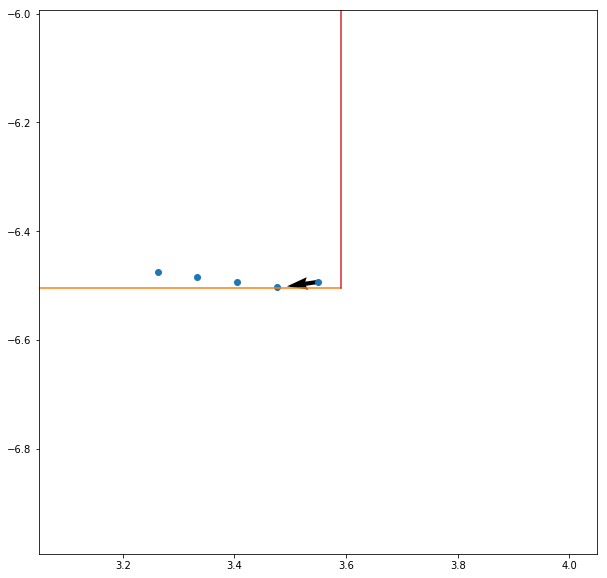

In [27]:
m1,n1 = preds[0,[0,2]]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(m1-0.5, m1+0.5), ylim=(n1-0.5,n1+0.5))

x,xv,y,yv = preds[0]
plt.quiver(x, y, xv, yv)
plt.scatter(preds[:5,0], preds[:5,2])
plt.plot([b1,b1],[c1,c2])
plt.plot([b1,b2],[c1,c1])
plt.plot([b1,b2],[c2,c2])
plt.plot([b2,b2],[c1,c2])

In [31]:
# fig.savefig('model_2d_preds_fromscratch.png')
# loss: 1.8051e-04 with 8 epochs

# For dense, same lossss was achieved with 225 epochs.

In [29]:
def save_model(model, model_str):
    model_json = model.to_json()
    with open('trained/'+model_str+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('trained/'+model_str+".h5")
    print("Saved model to disk")
# save_model(model_2d, 'model_2d_fromscratch')

In [47]:
%matplotlib notebook

In [48]:
frames = preds

<IPython.core.display.Javascript object>


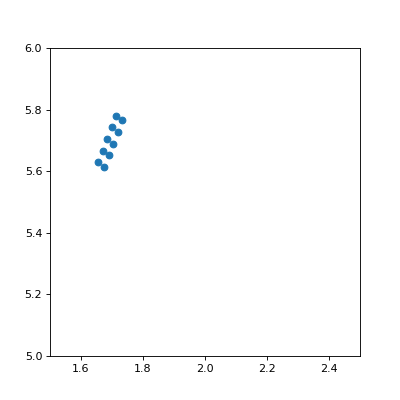

In [60]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(1.5, 2.5), ylim=(5, 6))

scat = ax.scatter( frames[:4,0], frames[:4,3])

def animate(i):
    t = np.array([frames[:i,0], frames[:i,2]]  )
    scat.set_offsets(t.T)

anim = FuncAnimation(
    fig, animate, interval=500, frames=100, repeat=False)

plt.draw()
plt.show()

In [52]:
frames

array([[ 1.6748883 , -0.09091698,  5.613918  , -0.01233546],
       [ 1.6550972 ,  0.09091698,  5.6291823 ,  0.01233546],
       [ 1.6894921 , -0.09091698,  5.651788  , -0.01233546],
       [ 1.6696926 ,  0.09091698,  5.667031  ,  0.01233546],
       [ 1.704079  , -0.09091698,  5.689615  , -0.01233546],
       [ 1.6842712 ,  0.09091698,  5.7048354 ,  0.01233546],
       [ 1.7186493 , -0.09091698,  5.7273974 , -0.01233546],
       [ 1.698833  ,  0.09091698,  5.742596  ,  0.01233546],
       [ 1.7332026 , -0.09091698,  5.7651362 , -0.01233546],
       [ 1.7133778 ,  0.09091698,  5.7803135 ,  0.01233546]],
      dtype=float32)

In [58]:
np.array([frames[:10,0], frames[:10,3]]).T

array([[ 1.6748883 , -0.01233546],
       [ 1.6550972 ,  0.01233546],
       [ 1.6894921 , -0.01233546],
       [ 1.6696926 ,  0.01233546],
       [ 1.704079  , -0.01233546],
       [ 1.6842712 ,  0.01233546],
       [ 1.7186493 , -0.01233546],
       [ 1.698833  ,  0.01233546],
       [ 1.7332026 , -0.01233546],
       [ 1.7133778 ,  0.01233546]], dtype=float32)